<a href="https://colab.research.google.com/github/SolPalominoH/challenge3-Telecom2/blob/main/Challenge_ONE_Data_Science_Telecom_X2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import requests
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [36]:
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

try:
    response = requests.get(url)
    response.raise_for_status()
    data = json.loads(response.text)

    print("Ok!")

except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")



Ok!


In [37]:
try:
    df = pd.DataFrame(data)
    print("ok!")

except Exception as e:
    print(f"Error creating DataFrame: {e}")
df.head()

ok!


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [38]:
customer_df = pd.json_normalize(df['customer'])
phone_df = pd.json_normalize(df['phone'])
internet_df = pd.json_normalize(df['internet'])
account_df = pd.json_normalize(df['account'])

df = pd.concat([df.drop(['customer', 'phone', 'internet', 'account'], axis=1), customer_df, phone_df, internet_df,account_df], axis=1)
df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


#Limpieza y preprocesamiento

In [39]:
def load_and_clean_data(filepath):
    """Carga y limpia el dataset"""
    df = pd.read_csv(filepath)

    # Limpieza básica
    df_datos_limpios = df.copy()
    df_datos_limpios['Churn'] = df_datos_limpios['Churn'].map({'Yes': 1, 'No': 0})
    df_datos_limpios['SeniorCitizen'] = df_datos_limpios['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

    # Eliminar columnas no necesarias
    cols_to_drop = ['customerID']
    if 'Unnamed: 0' in df_datos_limpios.columns:
        cols_to_drop.append('Unnamed: 0')
    df_datos_limpios = df_datos_limpios.drop(columns=cols_to_drop, errors='ignore')

    return df_datos_limpios

#Análisis de datos

In [40]:
def cramers_v(x, y):
    """Calcula el coeficiente V de Cramer para variables categóricas"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [41]:
def plot_distributions(df, columns, hue='Churn', max_cols=3):
    """Visualiza distribuciones de variables categóricas"""
    n_plots = len(columns)
    n_rows = (n_plots + max_cols - 1) // max_cols

    plt.figure(figsize=(18, 5*n_rows))
    for i, col in enumerate(columns, 1):
        plt.subplot(n_rows, max_cols, i)
        sns.countplot(data=df_datos_limpios, x=col, hue=hue)
        plt.title(f'{col} vs Churn')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [42]:
def plot_correlations(df, num_cols, cat_cols):
    """Visualiza correlaciones numéricas y categóricas"""
    # Correlación numérica
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_datos_limpios[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', center=0)
    plt.title('Correlación entre Variables Numéricas')
    plt.show()

    # Correlación categórica
    cramer_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    for col1 in cat_cols:
        for col2 in cat_cols:
            cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    plt.figure(figsize=(14, 12))
    sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=0, vmax=1)
    plt.title('Correlación Categórica (V de Cramer)')
    plt.show()

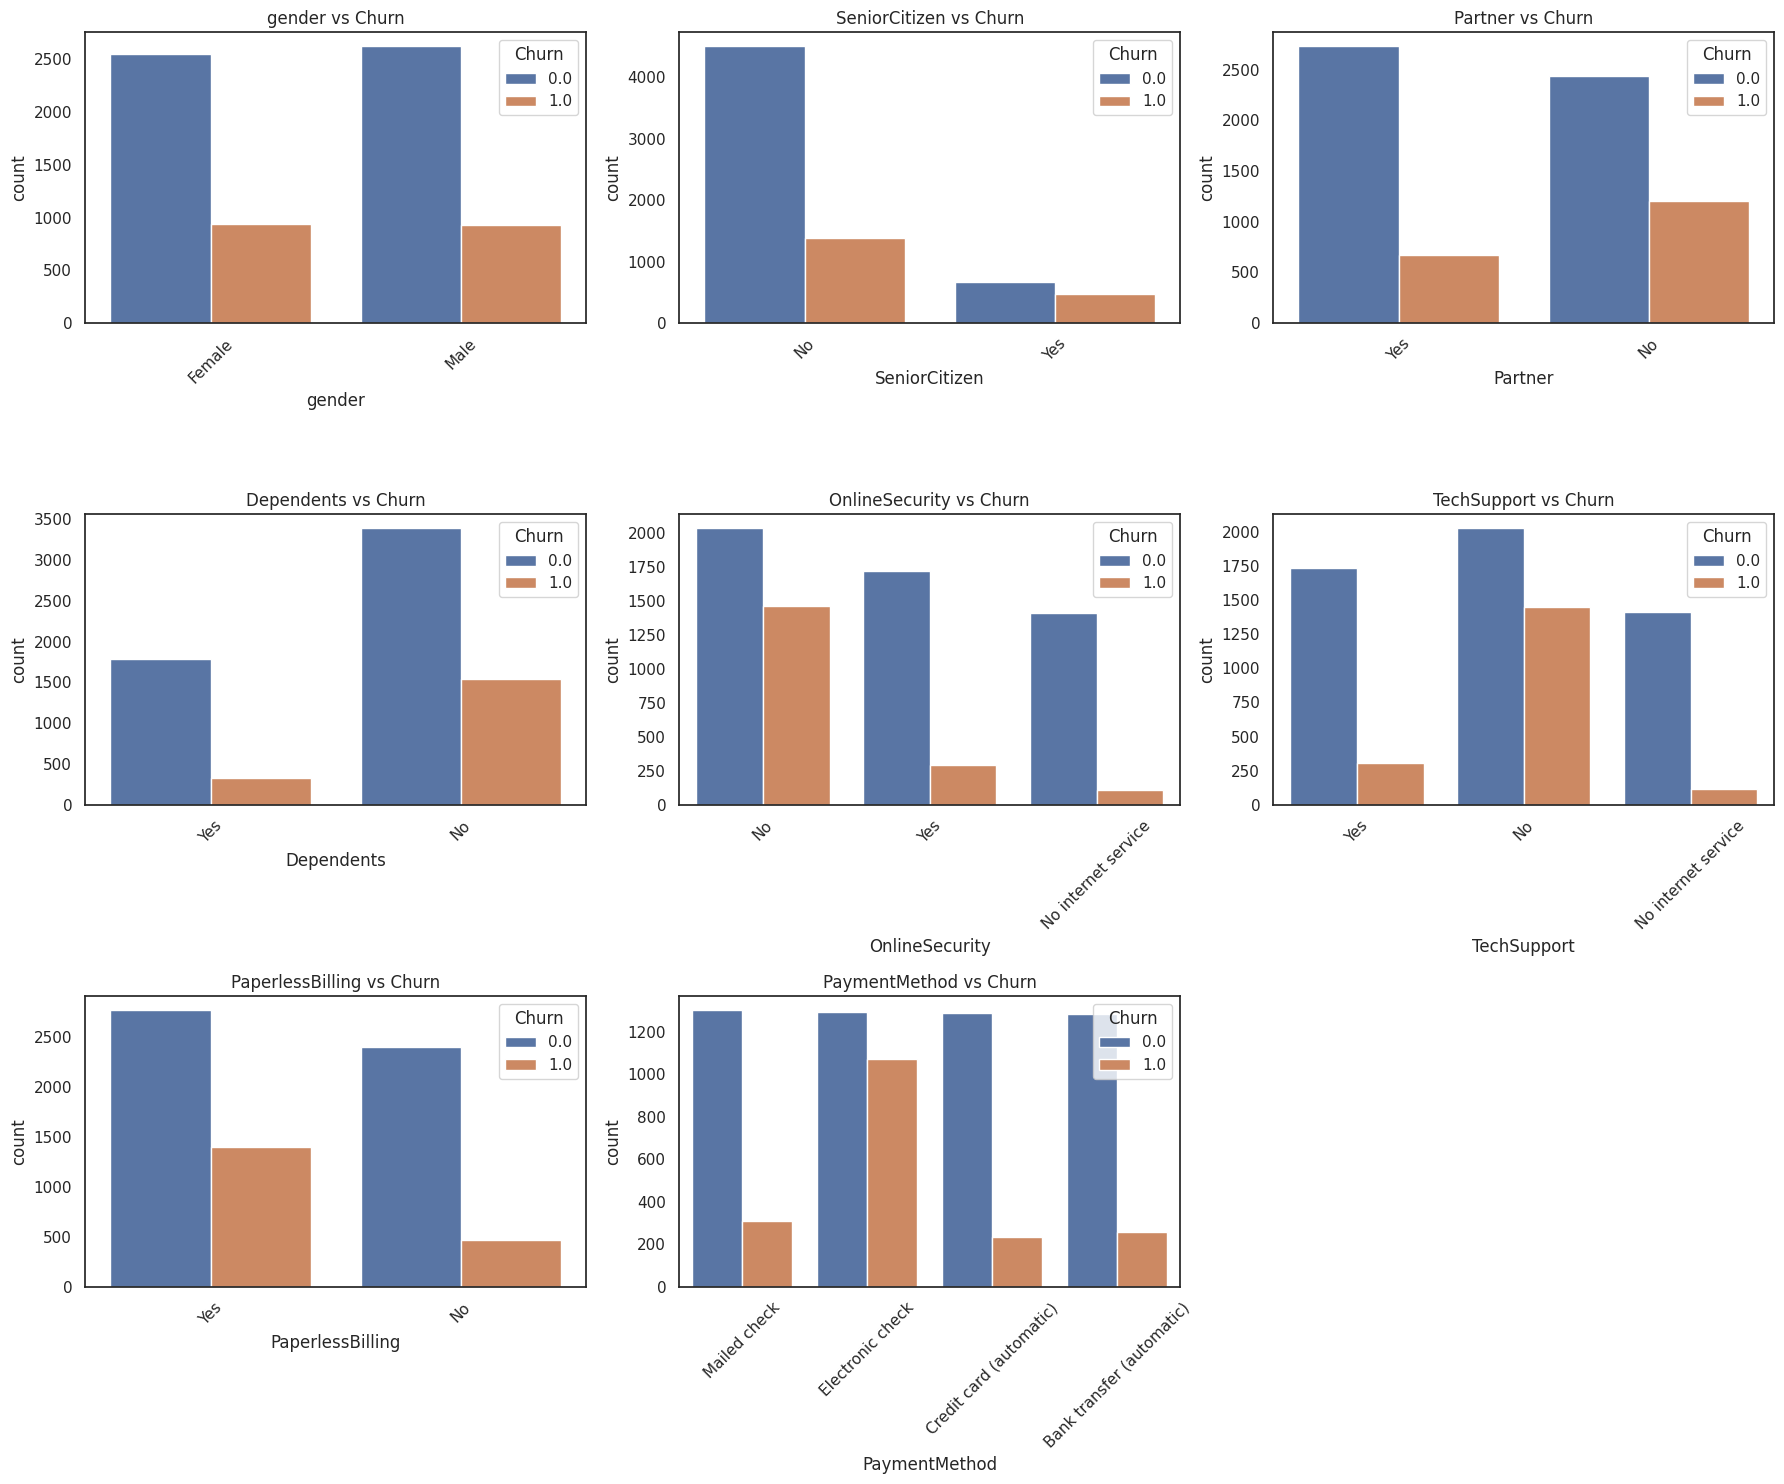

NameError: name 'num_cols' is not defined

In [44]:
def plot_numerical_vs_churn(df, num_cols):
    """Visualiza la relación entre variables numéricas y churn"""
    plt.figure(figsize=(16, 4))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(1, len(num_cols), i)
        sns.boxplot(data=df_datos_limpios, x='Churn', y=col)
        plt.title(f'{col} vs Churn')
    plt.tight_layout()
    plt.show()

cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
           'OnlineSecurity', 'TechSupport',
           'PaperlessBilling', 'PaymentMethod']

df_datos_limpios = df.copy()
# Verifica si 'Churn' es categórica 'Yes'/'No' o numérica 0/1 antes de mapear
if df_datos_limpios['Churn'].dtype == 'object':
     df_datos_limpios['Churn'] = df_datos_limpios['Churn'].map({'Yes': 1, 'No': 0})
# Verifica si 'SeniorCitizen' es numérica 0/1 o categórica 'Yes'/'No'
if df_datos_limpios['SeniorCitizen'].dtype != 'object':
    df_datos_limpios['SeniorCitizen'] = df_datos_limpios['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Eliminar columnas no necesarias - asegurate de que customerID exista si lo intentas eliminar
cols_to_drop = []
if 'customerID' in df_datos_limpios.columns:
    cols_to_drop.append('customerID')
if 'Unnamed: 0' in df_datos_limpios.columns: # Check if this column exists after JSON normalization
    cols_to_drop.append('Unnamed: 0')
if cols_to_drop:
    df_datos_limpios = df_datos_limpios.drop(columns=cols_to_drop, errors='ignore')


plot_distributions(df_datos_limpios, cat_cols)
plot_numerical_vs_churn(df_datos_limpios, num_cols)
plot_correlations(df_datos_limpios, num_cols, cat_cols[:8])

In [58]:
def analizeSeg(dfLimpio, segCols, target='Churn', paleta='husl'):
    """Analiza tasas de churn por segmentos de forma minimalista"""

    sns.set(style="white")

    for col in segCols:
        fig, ax = plt.subplots(figsize=(10, 5))

        segData = dfLimpio.groupby(col)[target].mean().sort_values(ascending=False)

        sns.barplot(x=segData.index, y=segData.values, palette=colors, ax=ax)

        ax.set_title(f'Tasa de Churn por {col}', fontsize=14, pad=15)
        ax.set_ylabel('Tasa de Churn', fontsize=12)
        ax.set_xlabel('')

        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1%}',
                       (p.get_x() + p.get_width()/2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 5), textcoords='offset points', fontsize=10)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        plt.tight_layout()
        plt.show()

        print(f"\nDistribución y churn por {col}:")
        display(pd.concat([
            dfLimpio[col].value_counts(normalize=True).rename('Distribución').mul(100).round(1).astype(str) + '%',
            dfLimpio.groupby(col)[target].mean().rename('Tasa Churn').mul(100).round(1).astype(str) + '%'
        ], axis=1).sort_values('Tasa Churn', ascending=False))


/tmp/ipython-input-2376566123.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




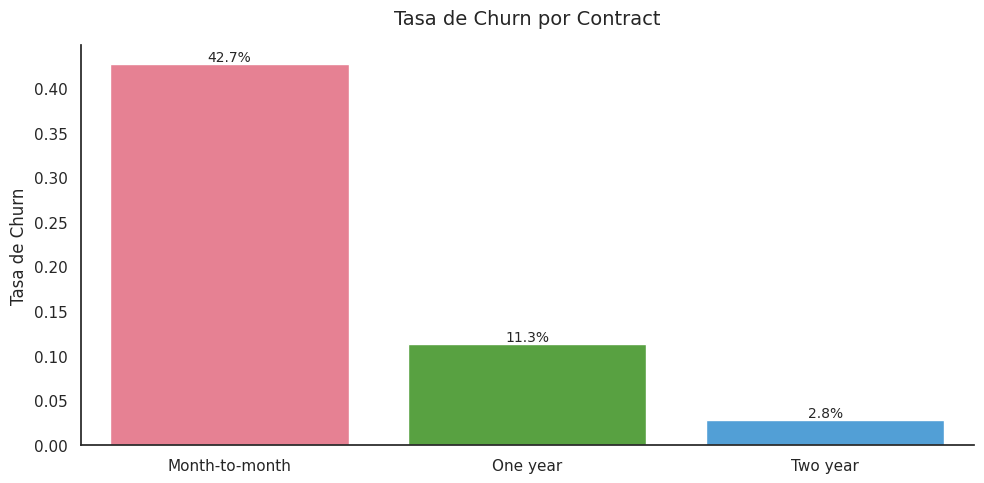


Distribución y churn por Contract:


,Distribución,Tasa Churn
Contract,,
Month-to-month,55.1%,42.7%
Two year,24.0%,2.8%
One year,20.9%,11.3%


/tmp/ipython-input-2376566123.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




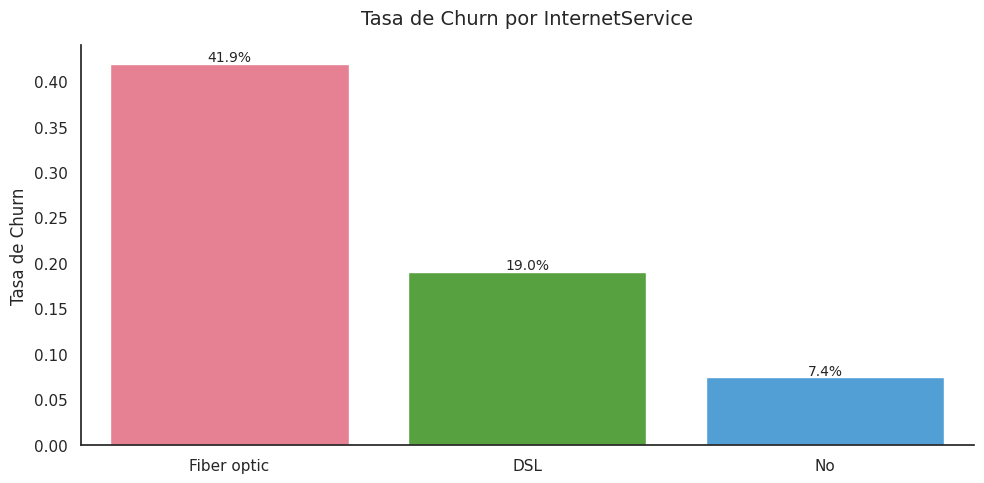


Distribución y churn por InternetService:


,Distribución,Tasa Churn
InternetService,,
No,21.8%,7.4%
Fiber optic,44.0%,41.9%
DSL,34.2%,19.0%


/tmp/ipython-input-2376566123.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




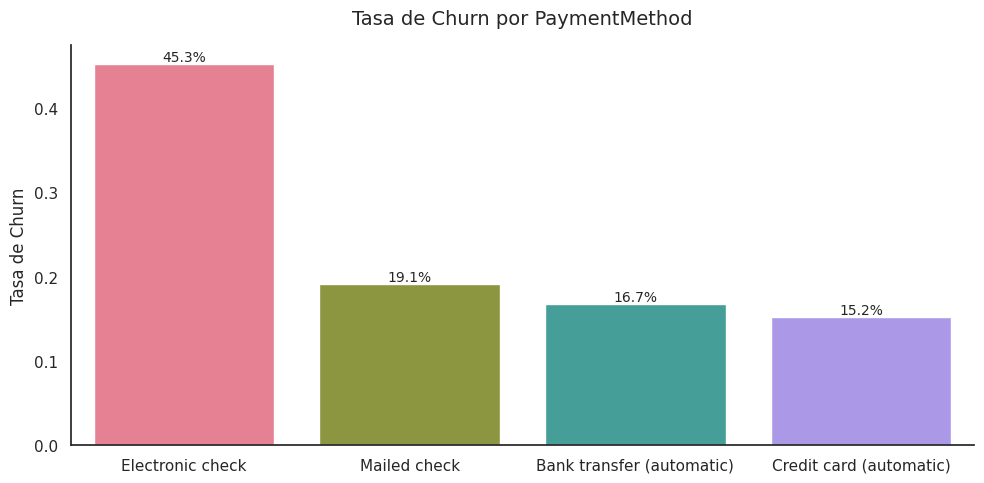


Distribución y churn por PaymentMethod:


,Distribución,Tasa Churn
PaymentMethod,,
Electronic check,33.6%,45.3%
Mailed check,22.9%,19.1%
Bank transfer (automatic),21.9%,16.7%
Credit card (automatic),21.6%,15.2%


In [59]:
# Segmentación clave
analyze_segments(df_datos_limpios, ['Contract', 'InternetService', 'PaymentMethod'])

In [ ]:
## Feature Engineering
def create_new_features(df):
    """Crea nuevas características para el modelado"""
    df_fe = df_datos_limpios.copy()

    # Servicios adicionales contratados
    services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies']
    df_fe[services] = df_fe[services].replace({'No internet service': 'No'}) # Limpiamos los valores para que solo sean Yes/No
    df_fe['NumServices'] = df_fe[services].apply(lambda x: sum(x == 'Yes'), axis=1)

    # Grupo de antigüedad
    df_fe['TenureGroup'] = pd.cut(df_fe['tenure'], bins=[0, 12, 24, 48, 72],
                                labels=['0-1 año', '1-2 años', '2-4 años', '4+ años'])

    # Cliente con servicios premium
    df_fe['PremiumCustomer'] = ((df_fe['InternetService'] == 'Fiber optic') &
                               (df_fe['Charges.Monthly'] > df_fe['Charges.Monthly'].median())).astype(int)

    return df_fe

df = create_new_features(df)

##  Factores críticos que aumentan el Churn


In [26]:
import plotly.express as px
px.defaults.width = 1000
px.defaults.height = 500

# Gráfico interactivo de churn por grupo de antigüedad con paleta 'Viridis'
fig_tenure = px.bar(
    df.groupby('TenureGroup')['Churn'].mean().reset_index(),
    x='TenureGroup',
    y='Churn',
    title='Tasa de Churn por Grupo de Antigüedad',
    labels={'Churn': 'Tasa de Churn', 'TenureGroup': 'Grupo de Antigüedad (meses)'},
    color='Churn',
    color_continuous_scale='Viridis',
    width=1000,  # 10 pulgadas
    height=500   # 5 pulgadas
).update_layout(
    yaxis_tickformat=".0%",  # Formato porcentual
    coloraxis_colorbar=dict(title="Tasa Churn"),
    title_x=0.5  # Centrar título
)

# Gráfico interactivo de churn por tipo de contrato con paleta 'Plasma'
fig_contract = px.bar(
    df.groupby('Contract')['Churn'].mean().reset_index(),
    x='Contract',
    y='Churn',
    title='Tasa de Churn por Tipo de Contrato',
    labels={'Churn': 'Tasa de Churn', 'Contract': 'Tipo de Contrato'},
    color='Churn',
    color_continuous_scale='Plasma',
    width=1000,  # 10 pulgadas
    height=500   # 5 pulgadas
).update_layout(
    yaxis_tickformat=".0%",  # Formato porcentual
    coloraxis_colorbar=dict(title="Tasa Churn"),
    title_x=0.5  # Centrar título
)

# Mostrar gráficos
fig_tenure.show()
fig_contract.show()





KeyError: 'TenureGroup'

## Factores protectores contra el Churn


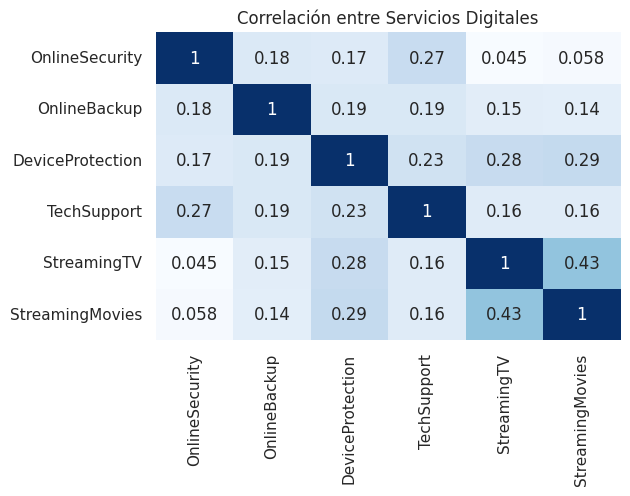

KeyError: 'PremiumCustomer'

In [53]:

digital_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
service_corr = df[digital_services].apply(lambda x: x.map({'Yes': 1, 'No': 0})).corr()

plt.figure(figsize=(6,4))
sns.heatmap(service_corr, annot=True, cmap='Blues', cbar=False)
plt.title('Correlación entre Servicios Digitales', fontsize=12)
plt.show()

# Churn por cliente Premium
fig_premium = px.bar(
    df.groupby('PremiumCustomer')['Churn'].mean().reset_index(),
    x='PremiumCustomer', y='Churn',
    title='Churn por Tipo de Cliente',
    labels={'Churn': 'Tasa de Churn', 'PremiumCustomer': 'Cliente Premium'},
    text='Churn'
)
fig_premium.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig_premium.update_xaxes(tickvals=[0, 1], ticktext=['No Premium', 'Premium'])
fig_premium.show()

#  Churn por contrato
contract_churn = df.groupby('Contract')['Churn'].mean().reset_index()

fig_contract = px.bar(
    contract_churn,
    x='Contract', y='Churn',
    title='Churn por Tipo de Contrato',
    labels={'Churn': 'Tasa de Churn (%)', 'Contract': 'Tipo de Contrato'},
    text='Churn'
)
fig_contract.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig_contract.show()

# Churn por número de servio
fig_services = px.bar(
    df.groupby('NumServices')['Churn'].mean().reset_index(),
    x='NumServices', y='Churn',
    title='Churn por Número de Servicios',
    labels={'Churn': 'Tasa de Churn', 'NumServices': 'N° Servicios'},
    text='Churn'
)
fig_services.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig_services.show()


In [49]:
# Segmentación avanzada
df['ServiceGroup'] = df['OnlineSecurity'] + '_' + df['TechSupport']
contract_payment_churn = df.groupby(['Contract', 'PaymentMethod', 'ServiceGroup'])['Churn'].mean().unstack()

plt.figure(figsize=(10,6))
sns.heatmap(contract_payment_churn, annot=True, fmt='.1%', cmap='YlOrRd')
plt.title('Tasa de Churn por Contrato, Método de Pago y Grupo de Servicios')
plt.show()

TypeError: agg function failed [how->mean,dtype->object]

## Patrones en variables numéricas


**Cargos Mensuales (MonthlyCharges):** Los clientes con Churn tienden a pagar tarifas más altas (mediana ≈$80 vs. ≈$60 de los no Churn). Esto podría reflejar insatisfacción con el precio o falta de percepción de valor.

**Antigüedad (tenure):** La mediana de antigüedad de los clientes que abandonan es mucho menor (≈10 meses) frente a los que se quedan (≈40 meses), reforzando la importancia de programas de fidelización temprana.

In [52]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Cargos Mensuales", "Antigüedad (meses)"))

# gráfico 1: cargos mensuales
fig.add_trace(
    go.Violin(x=df['Churn'],
              y=df['Charges.Monthly'],
              box_visible=True,
              meanline_visible=True,
              points=False),
    row=1, col=1
)

# gráfico 2: antigüedad
fig.add_trace(
    go.Violin(x=df['Churn'],
              y=df['tenure'],
              box_visible=True,
              meanline_visible=True,
              points=False),
    row=1, col=2
)

# diseño simple
fig.update_layout(
    title_text="Churn vs Variables Clave",
    height=450,
    showlegend=False,
    violingap=0.3,
    violinmode='overlay'
)

fig.show()


In [51]:

df['CLV'] = df['Charges.Monthly'] * df['tenure']
churn_clv = df.groupby(pd.qcut(df['CLV'], q=5))['Churn'].mean()

plt.figure(figsize=(8,4))
sns.barplot(x=churn_clv.index.astype(str), y=churn_clv.values, palette='viridis')
plt.title('Tasa de Churn por Quintil de Valor de Cliente (CLV)')
plt.ylabel('Tasa de Churn')
plt.xlabel('Quintiles de CLV (MonthlyCharges * Tenure)')
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-2304828151.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



TypeError: agg function failed [how->mean,dtype->object]

#Conclusiones

El estudio del comportamiento de los clientes muestra que el abandono del servicio no es un evento aleatorio, sino el resultado de una combinación de factores que inciden directamente en la decisión de quedarse o retirarse. Entre los más relevantes se encuentran los contratos de corta duración, la ausencia de servicios digitales clave y los métodos de pago poco prácticos, que en conjunto generan una alta vulnerabilidad a la pérdida de clientes. En contraste, los contratos a largo plazo funcionan como un fuerte mecanismo de retención: quienes optan por planes anuales o bianuales presentan tasas de abandono notablemente más bajas, efecto que se refuerza cuando además cuentan con soporte técnico y seguridad en línea. Por el contrario, los usuarios con contratos mensuales sin acceso a estos servicios presentan niveles de churn que superan el 40% en ciertos segmentos, lo que evidencia un riesgo crítico para la compañía.

Además, se identificaron diferencias significativas por perfil demográfico. En particular, los clientes senior tienden a abandonar el servicio con mayor frecuencia durante su primer año de relación, aunque, si permanecen más allá de ese período, se convierten en un segmento altamente fiel. Este hallazgo subraya la importancia de diseñar estrategias específicas de acompañamiento y retención temprana para este grupo. En general, las recomendaciones apuntan a fomentar la migración hacia contratos anuales mediante beneficios adicionales, implementar programas de onboarding e incentivos en los primeros meses, empaquetar servicios digitales con descuentos o pruebas gratuitas, optimizar los métodos de pago para evitar fricciones y establecer programas diferenciados de fidelización, especialmente para clientes con alto valor de vida y para adultos mayores en sus primeros meses de servicio.